In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

import seaborn as sns
#import maplotlib.pyplot as plt

In [84]:


def tts_scale(x, y, scaler, encoding=None, test_size=None, random_state=None):
    '''
    Helper function to correctly train-test-split, scale numerical columns, and one-hot-encode categorical features.
    Will return x_train, x_test, y_train, y_test.
    
    Parameters:
    x         ==> input variables from dataframe.
    y         ==> target variable from dataframe.
    encoding  ==> iterable of columns from dataframe to be one-hot-encoded.
    ts        ==> test size from train-test-split.
    rs        ==> random_state for train_test_split function.
    scaler    ==> scaling object used to scale numeric data for x_train and x_test.
    
    '''
    
    if(type(x) != type(pd.DataFrame()) and type(x) != type(pd.Series())):
        raise TypeError('X must be a Pandas DataFrame or Pandas Series.')

    if(type(y) != type(pd.DataFrame()) and type(y) != type(pd.Series())):
        raise TypeError('X must be a Pandas DataFrame or Pandas Series.')
    

    num_cols = x.corr().columns
    cat_cols = []
    
    for col in x.columns:
        if col not in num_cols:
            cat_cols.append(col)
    

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)
    

    
    try:
        x_train_s = pd.DataFrame(scaler.fit_transform(x_train[num_cols]), columns=num_cols)
        x_test_s = pd.DataFrame(scaler.fit_transform(x_test[num_cols]), columns=num_cols)

        x_train_s = x_train_s.set_index(x_train.index)
        x_test_s = x_test_s.set_index(x_test.index)
    except AttributeError:
        raise TypeError('The type of this scaler is not allowed.')

    if encoding is not None:
        
        x_train_cat = pd.get_dummies(x_train[cat_cols],columns=encoding)
        x_test_cat = pd.get_dummies(x_test[cat_cols],columns=encoding)
        x_train_final = pd.merge(x_train_s, x_train_cat, left_index=True, right_index=True)
        x_test_final = pd.merge(x_test_s, x_test_cat, left_index=True, right_index=True)
        
        return x_train_final, x_test_final, y_train, y_test

    else:

        return x_train_s, x_test_s, y_train, y_test
    

In [85]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns',45)

In [87]:
df = pd.read_csv(r'final.csv',index_col=0)
df = df[df['Credit Risk Code'].notna()]
df['Credit Risk Code'] = df['Credit Risk Code'].astype(str)

#### Drop Credit Risk Codes 4.5 and 6.5

In [88]:
df = df[df['Credit Risk Code']!= '4.5']
df = df[df['Credit Risk Code']!= '6.5']

#### Make Binned Risk Ratings - "Risk"

In [89]:
df.loc[df['Credit Risk Code'].isin(['1.0','2.0','3.0']), 'Risk'] = -1
df.loc[df['Credit Risk Code'].isin(['4.0','5.0','6.0','7.0']), 'Risk'] = 0
df.loc[df['Credit Risk Code'].isin(['8.0','9.0','10.0']), 'Risk'] = 1

In [90]:
X = df.drop(columns=['PK','Credit Risk Code','Default','Qdate','Risk','Adversity','QTR_CLOSE'])
Y = df['Risk']

In [91]:
x_train, x_test, y_train, y_test = tts_scale(X, Y, StandardScaler(), encoding=[], test_size=0.3, random_state=42)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


## Logistic Regression

In [92]:
#x_train = x_train.drop(columns=['Adversity','QTR_CLOSE','Qdate','Past_Due90+']) #have to drop pastdue90+ - getting 100%
#x_test = x_test.drop(columns=['Adversity','QTR_CLOSE','Qdate','Past_Due90+'])

In [93]:
x_train = x_train.set_index(['Date'])
x_test = x_test.set_index(['Date'])

In [94]:
X = pd.concat([x_train,x_test])

In [95]:
#x_train

In [96]:
'''
#BEWARE takes 9 minutes to run
log_reg = LogisticRegression(random_state=42,solver='lbfgs',max_iter=1000)

params={'C': [15,20,25,30]}

clf = GridSearchCV(log_reg,params,cv=5,verbose = 1, scoring = 'accuracy')

clf.fit(x_train, y_train)

DF=pd.DataFrame(clf.cv_results_)
DFF=DF[["param_C","mean_test_score","rank_test_score"]]
DFF #did not converge with 500 iterations. 10k iterations- best value: 15
'''

'\n#BEWARE takes 9 minutes to run\nlog_reg = LogisticRegression(random_state=42,solver=\'lbfgs\',max_iter=1000)\n\nparams={\'C\': [15,20,25,30]}\n\nclf = GridSearchCV(log_reg,params,cv=5,verbose = 1, scoring = \'accuracy\')\n\nclf.fit(x_train, y_train)\n\nDF=pd.DataFrame(clf.cv_results_)\nDFF=DF[["param_C","mean_test_score","rank_test_score"]]\nDFF #did not converge with 500 iterations. 10k iterations- best value: 15\n'

In [97]:
#Run model with Best C value found above
log_reg = LogisticRegression( C=30,random_state=42,solver='lbfgs',max_iter=1000) #max_iter=100, default, did not converge
log_reg.fit(x_train, y_train)

LogisticRegression(C=30, max_iter=1000, random_state=42)

In [98]:
predictions = log_reg.predict(x_test)

In [99]:
#print(log_reg.coef_, log_reg.intercept_)

In [100]:
a=pd.DataFrame(zip(x_train.columns, np.transpose(log_reg.coef_.tolist()[0])), columns=['features', 'coef']).sort_values(by=['coef'])
a['coef'] = a['coef'].round(decimals=1)
a.reindex(a.coef.abs().sort_values(ascending=False).index).head(20)

,features,coef
4,Past_Due90+,-1.0
2,Past_Due30_59,-0.9
1,Days Past Due,-0.9
0,Balance,-0.2
11,THREE_MONTH_TREASURY_RATE,0.1
12,FIVE_YEAR_TREASURY_YIELD,-0.1
3,Past_Due60_89,-0.1
23,EURO_AREA_BILATERAL_DOLLAR_EXCHANGE_RATE,-0.1
20,MARKET_VOLATILITY_INDEX,-0.1
22,EURO_AREA_INFLATION,-0.1


In [101]:
pd.DataFrame(np.array(x_train.columns).reshape(11,3))

,0,1,2
0,Balance,Days Past Due,Past_Due30_59
1,Past_Due60_89,Past_Due90+,REAL_GDP_GROWTH
2,NOMINAL_GDP_GROWTH,REAL_DISPOSABLE_INCOME_GROWTH,NOMINAL_DISPOSABLE_INCOME_GROWTH
3,UNEMPLOYMENT_RATE,CPI_INFLATION_RATE,THREE_MONTH_TREASURY_RATE
4,FIVE_YEAR_TREASURY_YIELD,TEN_YEAR_TREASURY_YIELD,BBB_CORPORATE_YEILD
5,MORTGAGE_RATE,PRIME_RATE,DOWJONES_TOTAL_STOCK_MARKET_INDEX
6,HOUSE_PRICE_INDEX,COMERCIAL_REAL_ESTATE_PRICE_INDEX,MARKET_VOLATILITY_INDEX
7,EURO_AREA_REAL_GDP_GROWTH,EURO_AREA_INFLATION,EURO_AREA_BILATERAL_DOLLAR_EXCHANGE_RATE
8,DEVELOPING_ASIA_REAL_GDP_GROWTH,DEVELOPING_ASIA_INFLATION,DEV_ASIA_BILATERAL_DOLLAR_EXCHANGE_RATE
9,JAPAN_REAL_GDP_GROWTH,JAPAN_INFLATION,JAPAN_BILATERAL_DOLLAR_EXCHANGE_RATE


In [102]:
sc=log_reg.score(x_test, y_test)
print("The model's mean accuracy score on the test set it", sc)

The model's mean accuracy score on the test set it 0.6890561375641365


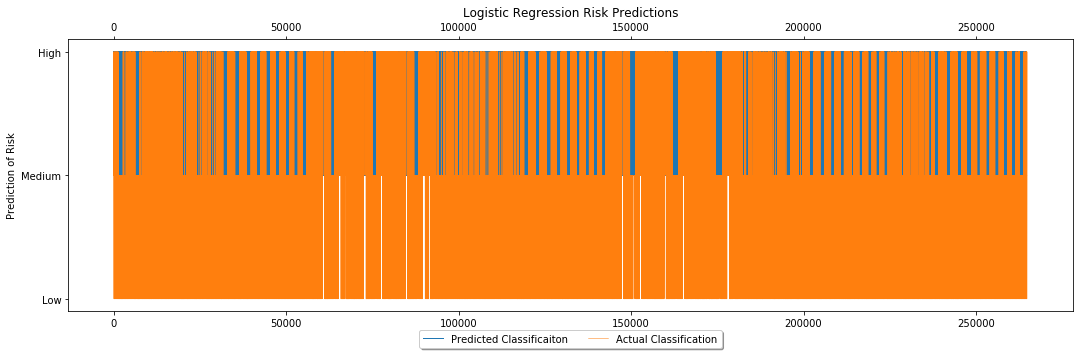

In [124]:
y_pred=np.around(log_reg.predict_proba(X))
y_pred=y_pred[:,1]
plt.figure(figsize=(18,5))
plt.plot(y_pred,linewidth=1, label='Predicted Classificaiton')
plt.plot(Y,linewidth=.5, label='Actual Classification')

plt.title('Logistic Regression Risk Predictions')
plt.ylabel('Prediction of Risk')
plt.xlabel('Observations')
plt.yticks(np.arange(-1,2),('Low', 'Medium', 'High'))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)

#blue line- true classification
#orange line prediction, so where you see the blue misclassificaiton 

In [105]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[42891  1767   118]
 [20553  7232   703]
 [  301  1223  4535]]
              precision    recall  f1-score   support

        -1.0       0.67      0.96      0.79     44776
         0.0       0.71      0.25      0.37     28488
         1.0       0.85      0.75      0.79      6059

    accuracy                           0.69     79323
   macro avg       0.74      0.65      0.65     79323
weighted avg       0.70      0.69      0.64     79323



In [112]:
cm = confusion_matrix(y_test, predictions)
cm_abbrev = np.around(cm/1000,decimals=1)

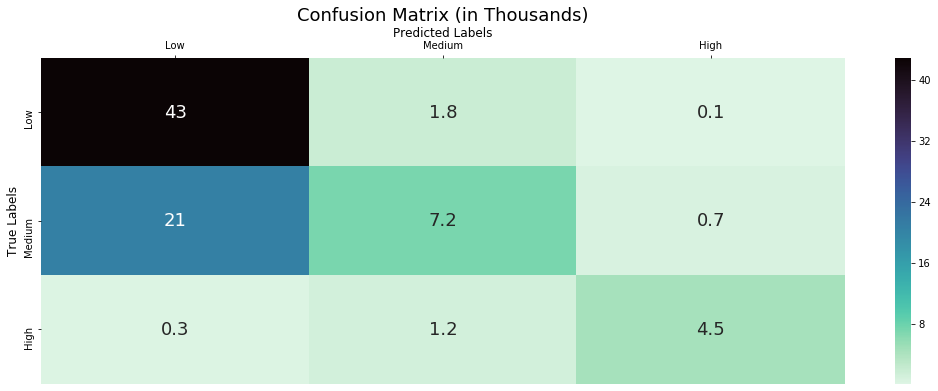

In [116]:
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
fig = plt.figure(figsize=(18, 6)) 
ax = plt.subplot()
sns.heatmap(cm_abbrev, annot=True, ax=ax, cmap="mako_r",annot_kws={"fontsize":18})
ax.set_xlabel('Predicted Labels',fontsize=12)
ax.set_ylabel('True Labels',fontsize=12)
ax.set_title('Confusion Matrix (in Thousands)', fontsize=18)
ax.xaxis.set_ticklabels(['Low','Medium','High'])
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.yaxis.set_ticklabels(['Low','Medium', 'High']);